In [209]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from multiview.cotraining.ctclassifier import CTClassifier
from multiview.datasets.base import load_UCImultifeature

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


### Performance on simulated data

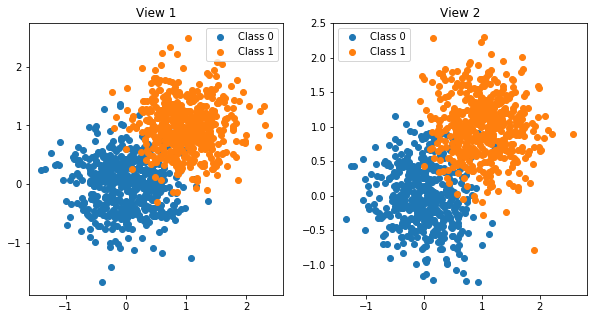

In [210]:
# One class is centered at [0,0] other is at [1,1]
np.random.seed(12)
N_per_class = 500

view1_mu0 = np.zeros(2,)
view1_mu1 = np.ones(2,)
view1_cov = .2*np.eye(2)

view2_mu0 = np.zeros(2,)
view2_mu1 = np.ones(2,)
view2_cov = .2*np.eye(2)

view1_class0 = np.random.multivariate_normal(view1_mu0, view1_cov, size=N_per_class)
view1_class1 = np.random.multivariate_normal(view1_mu1, view1_cov, size=N_per_class)

view2_class0 = np.random.multivariate_normal(view2_mu0, view2_cov, size=N_per_class)
view2_class1 = np.random.multivariate_normal(view2_mu1, view2_cov, size=N_per_class)

View1 = np.concatenate((view1_class0, view1_class1))
View2 = np.concatenate((view2_class0, view2_class1))
Labels = np.concatenate((np.zeros(N_per_class,), np.ones(N_per_class,)))


# plot the views
plt.figure()
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(view1_class0[:,0], view1_class0[:,1])
ax[0].scatter(view1_class1[:,0], view1_class1[:,1])
ax[0].set_title('View 1')
ax[0].legend(('Class 0', 'Class 1'))

ax[1].scatter(view2_class0[:,0], view2_class0[:,1])
ax[1].scatter(view2_class1[:,0], view2_class1[:,1])
ax[1].set_title('View 2')
ax[1].legend(('Class 0', 'Class 1'))

plt.show()





#### Example of a single run 

labeled indices
[276 560 699]
[392 525]


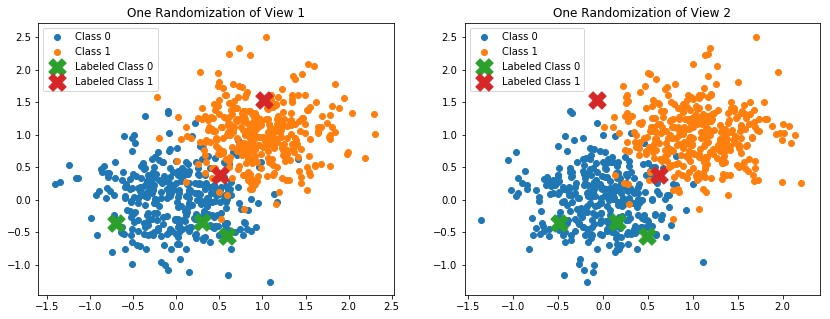

0.91
0.5


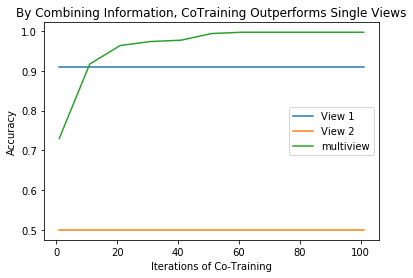

In [211]:
view2_penalty='l1'
# Split both views into testing and training
View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, Labels, test_size=0.3, random_state=42)
View2_train, View2_test, labels_train_full, labels_test_full = train_test_split(View2, Labels, test_size=0.3, random_state=42)

labels_train = labels_train_full.copy()
labels_test = labels_test_full.copy()


idx_train_0 = np.where(labels_train==0)
idx_train_1 = np.where(labels_train==1)


# randomly remove some labels
np.random.seed(11)
remove_idx = np.random.rand(len(labels_train),) < .99
labels_train[remove_idx] = np.nan
not_removed = np.where(remove_idx==False)[0]
#print(not_removed[np.where(labels_train[not_removed]==0)])

labeled_idx_class0 = not_removed[np.where(labels_train[not_removed]==0)]
labeled_idx_class1 = not_removed[np.where(labels_train[not_removed]==1)]

print("labeled indices")
print(labeled_idx_class0)
print(labeled_idx_class1)


# plot the views
plt.figure()
fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].scatter(View1_train[idx_train_0,0], View1_train[idx_train_0,1])
ax[0].scatter(View1_train[idx_train_1,0], View1_train[idx_train_1,1])
ax[0].scatter(View1_train[labeled_idx_class0,0], View1_train[labeled_idx_class0,1], s=300, marker='X')
ax[0].scatter(View1_train[labeled_idx_class1,0], View1_train[labeled_idx_class1,1], s=300, marker='X')
ax[0].set_title('One Randomization of View 1')
ax[0].legend(('Class 0', 'Class 1', 'Labeled Class 0', 'Labeled Class 1'))

ax[1].scatter(View2_train[idx_train_0,0], View1_train[idx_train_0,1])
ax[1].scatter(View2_train[idx_train_1,0], View1_train[idx_train_1,1])
ax[1].scatter(View2_train[labeled_idx_class0,0], View1_train[labeled_idx_class0,1], s=300, marker='X')
ax[1].scatter(View2_train[labeled_idx_class1,0], View1_train[labeled_idx_class1,1], s=300, marker='X')
ax[1].set_title('One Randomization of View 2')
ax[1].legend(('Class 0', 'Class 1', 'Labeled Class 0', 'Labeled Class 1'))

plt.show()

############## Single view semi-supervised learning ##############
#-----------------------------------------------------------------
# gnb0 = GaussianNB()
# gnb1 = GaussianNB()
gnb0 = LogisticRegression()
gnb1 = LogisticRegression(penalty=view2_penalty)
# gnb0 = KNeighborsClassifier()
# gnb1 = KNeighborsClassifier()

# Train on only the examples with labels
gnb0.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
y_pred0 = gnb0.predict(View1_test)

gnb1.fit(View2_train[not_removed,:].squeeze(), labels_train[not_removed])
y_pred1 = gnb1.predict(View2_test)

accuracy_view1 = (accuracy_score(labels_test, y_pred0))
accuracy_view2 = (accuracy_score(labels_test, y_pred1))

print(accuracy_view1)
print(accuracy_view2)

############## Multi-view semi-supervised learning ##############
#-----------------------------------------------------------------
N_iters = np.arange(1, 102, 10)
acc_ct = np.zeros(N_iters.shape)
for count, iters in enumerate(N_iters):
    
    ctc = CTClassifier()
    ctc = CTClassifier(LogisticRegression(), LogisticRegression(penalty=view2_penalty))
    ctc.fit([View1_train, View2_train], labels_train, num_iter=iters)
    y_pred_ct = ctc.predict([View1_test, View2_test])
    acc_ct[count] = acc_ct[count] + (accuracy_score(labels_test, y_pred_ct))
        

plt.figure()
plt.plot(N_iters, accuracy_view1*np.ones(N_iters.shape))
plt.plot(N_iters, accuracy_view2*np.ones(N_iters.shape))
plt.plot(N_iters, acc_ct)
plt.legend(('View 1', 'View 2', 'multiview'))
plt.ylabel('Accuracy')
plt.xlabel('Iterations of Co-Training')
plt.title('By Combining Information, CoTraining Outperforms Single Views')
plt.show()


#### Loop through many randomizations

In [212]:
randomizations = 20
N_per_class = 500
N_neigh = 2
view2_penalty = 'l1'

N_iters = np.arange(1, 202, 15)
acc_ct = [[] for _ in N_iters]
acc_view1 = []
acc_view2 = []


for count, iters in enumerate(N_iters):
    
    for seed in range(randomizations):
    
        ######################### Create Data ###########################
        np.random.seed(seed)

        view1_mu0 = np.zeros(2,)
        view1_mu1 = np.ones(2,)
        view1_cov = .2*np.eye(2)

        view2_mu0 = np.zeros(2,)
        view2_mu1 = np.ones(2,)
        view2_cov = .2*np.eye(2)

        view1_class0 = np.random.multivariate_normal(view1_mu0, view1_cov, size=N_per_class)
        view1_class1 = np.random.multivariate_normal(view1_mu1, view1_cov, size=N_per_class)

        view2_class0 = np.random.multivariate_normal(view2_mu0, view2_cov, size=N_per_class)
        view2_class1 = np.random.multivariate_normal(view2_mu1, view2_cov, size=N_per_class)

        View1 = np.concatenate((view1_class0, view1_class1))
        View2 = np.concatenate((view2_class0, view2_class1))
        Labels = np.concatenate((np.zeros(N_per_class,), np.ones(N_per_class,)))
    
        
        # Split both views into testing and training
        View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, Labels, test_size=0.3, random_state=42)
        View2_train, View2_test, labels_train_full, labels_test_full = train_test_split(View2, Labels, test_size=0.3, random_state=42)

        labels_train = labels_train_full.copy()
        labels_test = labels_test_full.copy()

        # randomly remove some labels
        np.random.seed(11)
        remove_idx = np.random.rand(len(labels_train),) < .99
        labels_train[remove_idx] = np.nan
        not_removed = np.where(remove_idx==False)[0]
        
        # make sure both classes have at least 1 labeled example
        if len(set(labels_train[not_removed])) != 2:
            continue

        
        ############## Single view semi-supervised learning ##############
        # Only once, since not affected by "num iters"
        if count == 0:
#             gnb0 = KNeighborsClassifier(n_neighbors=N_neigh) # LogisticRegression()
#             gnb1 = KNeighborsClassifier(n_neighbors=N_neigh) # LogisticRegression()
            gnb0 = LogisticRegression()
            gnb1 = LogisticRegression(penalty=view2_penalty)

            # Train on only the examples with labels
            gnb0.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred0 = gnb0.predict(View1_test)

            gnb1.fit(View2_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred1 = gnb1.predict(View2_test)

            accuracy_view1 = (accuracy_score(labels_test, y_pred0))
            accuracy_view2 = (accuracy_score(labels_test, y_pred1))

            acc_view1.append(accuracy_view1)
            acc_view2.append(accuracy_view2)
#             print("single view")
#             print(accuracy_view1)
#             print(accuracy_view2)


        ##################### Multiview ########################################
        ctc = CTClassifier(LogisticRegression(), LogisticRegression(penalty=view2_penalty))
        ctc.fit([View1_train, View2_train], labels_train, num_iter=iters)
        y_pred_ct = ctc.predict([View1_test, View2_test])
        acc_ct[count].append((accuracy_score(labels_test, y_pred_ct)))
#         print("cotraining")
#         print((accuracy_score(labels_test, y_pred_ct)))
        
acc_view1 = np.mean(acc_view1)
acc_view2 = np.mean(acc_view2)
print(len(acc_ct))
acc_ct = [sum(row) / float(len(row)) for row in acc_ct]




14


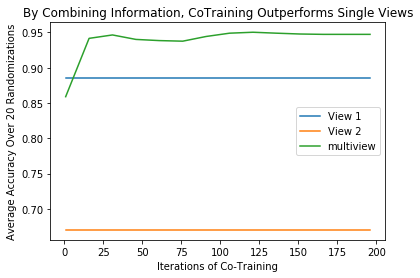

In [213]:
# make a figure from the data
plt.figure()
plt.plot(N_iters, acc_view1*np.ones(N_iters.shape))
plt.plot(N_iters, acc_view2*np.ones(N_iters.shape))
plt.plot(N_iters, acc_ct)
plt.legend(('View 1', 'View 2', 'multiview'))
plt.ylabel("Average Accuracy Over {} Randomizations".format(randomizations))
plt.xlabel('Iterations of Co-Training')
plt.title('By Combining Information, CoTraining Outperforms Single Views')
plt.show()

### Performance when labeled data is excellent

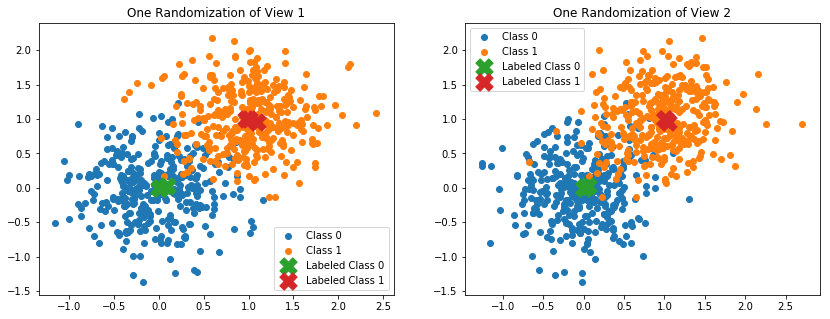

14


In [214]:
randomizations = 20
N_per_class = 500
num_perfect = 3
perfect_scale = 0.05
N_neigh = 2

N_iters = np.arange(1, 202, 15)
acc_ct = [[] for _ in N_iters]
acc_view1 = []
acc_view2 = []


for count, iters in enumerate(N_iters):
    
    for seed in range(randomizations):
    
        ######################### Create Data ###########################
        np.random.seed(seed)

        view1_mu0 = np.zeros(2,)
        view1_mu1 = np.ones(2,)
        view1_cov = .2*np.eye(2)

        view2_mu0 = np.zeros(2,)
        view2_mu1 = np.ones(2,)
        view2_cov = .2*np.eye(2)
        
        # generage perfect examples
        perfect_class0_v1 = view1_mu0 + np.random.normal(loc=0, scale=perfect_scale, size=view1_mu0.shape)
        perfect_class0_v2 = view1_mu0 + np.random.normal(loc=0, scale=perfect_scale, size=view1_mu0.shape)
        perfect_class1_v1 = view1_mu1 + np.random.normal(loc=0, scale=perfect_scale, size=view1_mu1.shape)
        perfect_class1_v2 = view1_mu1 + np.random.normal(loc=0, scale=perfect_scale, size=view1_mu1.shape)
        for p in range(1, num_perfect):
            perfect_class0_v1 = np.vstack((perfect_class0_v1, view1_mu0 + np.random.normal(loc=0, scale=0.01, size=view1_mu0.shape)))
            perfect_class0_v2 = np.vstack((perfect_class0_v2, view1_mu0 + np.random.normal(loc=0, scale=0.01, size=view1_mu0.shape)))
            perfect_class1_v1 = np.vstack((perfect_class1_v1, view1_mu1 + np.random.normal(loc=0, scale=0.01, size=view1_mu1.shape)))
            perfect_class1_v2 = np.vstack((perfect_class1_v2, view1_mu1 + np.random.normal(loc=0, scale=0.01, size=view1_mu1.shape)))
        perfect_labels = np.zeros(num_perfect,)
        perfect_labels = np.concatenate((perfect_labels, np.ones(num_perfect,)))
        
        
#         perfect_class1_v1 = view1_mu1 + np.random.normal(loc=0, scale=0.01, size=view1_mu1.shape)
#         perfect_class1_v2 = view1_mu1 + np.random.normal(loc=0, scale=0.01, size=view1_mu1.shape)
#         for p in range(1, num_perfect):
#             perfect_class1_v1 = np.vstack((perfect_class1, view1_mu1 + np.random.normal(loc=0, scale=0.01, size=view1_mu1.shape)))
#             perfect_class1_v2 = np.vstack((perfect_class1, view1_mu1 + np.random.normal(loc=0, scale=0.01, size=view1_mu1.shape)))


        view1_class0 = np.random.multivariate_normal(view1_mu0, view1_cov, size=N_per_class)
        view1_class1 = np.random.multivariate_normal(view1_mu1, view1_cov, size=N_per_class)

        view2_class0 = np.random.multivariate_normal(view2_mu0, view2_cov, size=N_per_class)
        view2_class1 = np.random.multivariate_normal(view2_mu1, view2_cov, size=N_per_class)

        View1 = np.concatenate((view1_class0, view1_class1))
        View2 = np.concatenate((view2_class0, view2_class1))
        Labels = np.concatenate((np.zeros(N_per_class,), np.ones(N_per_class,)))
    
        
        # Split both views into testing and training
        View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, Labels, test_size=0.3, random_state=42)
        View2_train, View2_test, labels_train_full, labels_test_full = train_test_split(View2, Labels, test_size=0.3, random_state=42)

        labels_train = labels_train_full.copy()
        labels_test = labels_test_full.copy()

        
        # Add the perfect examples
        View1_train = np.vstack((View1_train, perfect_class0_v1, perfect_class1_v1))
        View2_train = np.vstack((View2_train, perfect_class0_v2, perfect_class1_v2))
        labels_train = np.concatenate((labels_train, perfect_labels)) 
        
#         print(View1_train.shape)
#         print(View2_train.shape)
#         print(labels_train.shape)

        # randomly remove all but perfect labeled samples
        remove_idx = [True for i in range(len(labels_train)-2*num_perfect)]
        for i in range(2*num_perfect):
            remove_idx.append(False)
                                                 
        
        #remove_idx = [False if i < (len(labels_train)-2*num_perfect) else True for i in range(len(labels_train))]
        labels_train[remove_idx] = np.nan
        not_removed = np.where(remove_idx==False)[0]
        not_removed = np.arange(len(labels_train)-2*num_perfect, len(labels_train))
#         print(labels_train)
#         print(not_removed)
        
        # make sure both classes have at least 1 labeled example
        if len(set(labels_train[not_removed])) != 2:
            continue

        if seed == 0 and count == 0:
            
            labeled_idx_class0 = not_removed[np.where(labels_train[not_removed]==0)]
            labeled_idx_class1 = not_removed[np.where(labels_train[not_removed]==1)]
            
            # plot the views
            plt.figure()
            fig, ax = plt.subplots(1,2, figsize=(14,5))

            ax[0].scatter(View1_train[idx_train_0,0], View1_train[idx_train_0,1])
            ax[0].scatter(View1_train[idx_train_1,0], View1_train[idx_train_1,1])
            ax[0].scatter(View1_train[labeled_idx_class0,0], View1_train[labeled_idx_class0,1], s=300, marker='X')
            ax[0].scatter(View1_train[labeled_idx_class1,0], View1_train[labeled_idx_class1,1], s=300, marker='X')
            ax[0].set_title('One Randomization of View 1')
            ax[0].legend(('Class 0', 'Class 1', 'Labeled Class 0', 'Labeled Class 1'))

            ax[1].scatter(View2_train[idx_train_0,0], View1_train[idx_train_0,1])
            ax[1].scatter(View2_train[idx_train_1,0], View1_train[idx_train_1,1])
            ax[1].scatter(View2_train[labeled_idx_class0,0], View1_train[labeled_idx_class0,1], s=300, marker='X')
            ax[1].scatter(View2_train[labeled_idx_class1,0], View1_train[labeled_idx_class1,1], s=300, marker='X')
            ax[1].set_title('One Randomization of View 2')
            ax[1].legend(('Class 0', 'Class 1', 'Labeled Class 0', 'Labeled Class 1'))

            plt.show()
        
        ############## Single view semi-supervised learning ##############
        # Only once, since not affected by "num iters"
        if count == 0:
#             gnb0 = KNeighborsClassifier(n_neighbors=N_neigh) #LogisticRegression()
#             gnb1 = KNeighborsClassifier(n_neighbors=N_neigh) #LogisticRegression()
            gnb0 = LogisticRegression()
            gnb1 = LogisticRegression(penalty=view2_penalty)

            # Train on only the examples with labels
            gnb0.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred0 = gnb0.predict(View1_test)

            gnb1.fit(View2_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred1 = gnb1.predict(View2_test)

            accuracy_view1 = (accuracy_score(labels_test, y_pred0))
            accuracy_view2 = (accuracy_score(labels_test, y_pred1))

            acc_view1.append(accuracy_view1)
            acc_view2.append(accuracy_view2)
#             print("single view")
#             print(accuracy_view1)
#             print(accuracy_view2)


        ##################### Multiview ########################################
        ctc = CTClassifier(LogisticRegression(), LogisticRegression(view2_penalty))
        ctc.fit([View1_train, View2_train], labels_train, num_iter=iters)
        y_pred_ct = ctc.predict([View1_test, View2_test])
        acc_ct[count].append((accuracy_score(labels_test, y_pred_ct)))
#         print("cotraining")
#         print((accuracy_score(labels_test, y_pred_ct)))
        
acc_view1 = np.mean(acc_view1)
acc_view2 = np.mean(acc_view2)
print(len(acc_ct))
acc_ct = [sum(row) / float(len(row)) for row in acc_ct]

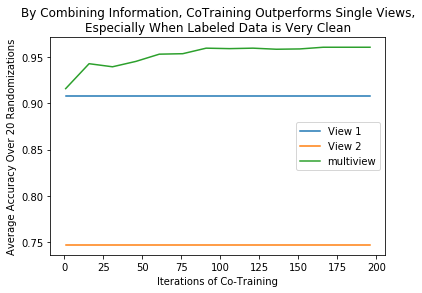

In [215]:
# make a figure from the data
plt.figure()
plt.plot(N_iters, acc_view1*np.ones(N_iters.shape))
plt.plot(N_iters, acc_view2*np.ones(N_iters.shape))
plt.plot(N_iters, acc_ct)
plt.legend(('View 1', 'View 2', 'multiview'))
plt.ylabel("Average Accuracy Over {} Randomizations".format(randomizations))
plt.xlabel('Iterations of Co-Training')
plt.title('By Combining Information, CoTraining Outperforms Single Views,\nEspecially When Labeled Data is Very Clean')
plt.show()

### Performance when labeled data is not as separable

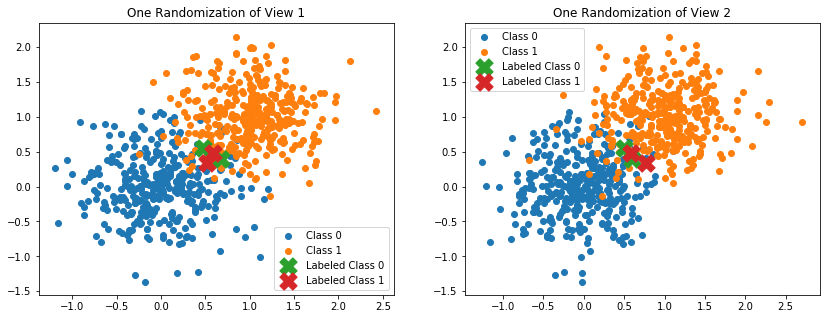

14


In [216]:
randomizations = 20
N_per_class = 500
num_perfect = 2
uniform_min = 0.2
uniform_max = 0.7
N_neigh = 2

N_iters = np.arange(1, 202, 15)
acc_ct = [[] for _ in N_iters]
acc_view1 = []
acc_view2 = []


for count, iters in enumerate(N_iters):
    
    for seed in range(randomizations):
    
        ######################### Create Data ###########################
        np.random.seed(seed)

        view1_mu0 = np.zeros(2,)
        view1_mu1 = np.ones(2,)
        view1_cov = .2*np.eye(2)

        view2_mu0 = np.zeros(2,)
        view2_mu1 = np.ones(2,)
        view2_cov = .2*np.eye(2)
        
        # generage bad examples
        perfect_class0_v1 = view1_mu0 + np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)
        perfect_class0_v2 = view1_mu0 + np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)
        perfect_class1_v1 = view1_mu1 - np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)
        perfect_class1_v2 = view1_mu1 - np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)
        for p in range(1, num_perfect):
            perfect_class0_v1 = np.vstack((perfect_class0_v1, view1_mu0 + np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)))
            perfect_class0_v2 = np.vstack((perfect_class0_v2, view1_mu0 + np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)))
            perfect_class1_v1 = np.vstack((perfect_class1_v1, view1_mu1 - np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)))
            perfect_class1_v2 = np.vstack((perfect_class1_v2, view1_mu1 - np.random.uniform(uniform_min, uniform_max, size=view1_mu0.shape)))
        perfect_labels = np.zeros(num_perfect,)
        perfect_labels = np.concatenate((perfect_labels, np.ones(num_perfect,)))
        
        
#         perfect_class1_v1 = view1_mu1 + np.random.normal(loc=0, scale=0.01, size=view1_mu1.shape)
#         perfect_class1_v2 = view1_mu1 + np.random.normal(loc=0, scale=0.01, size=view1_mu1.shape)
#         for p in range(1, num_perfect):
#             perfect_class1_v1 = np.vstack((perfect_class1, view1_mu1 + np.random.normal(loc=0, scale=0.01, size=view1_mu1.shape)))
#             perfect_class1_v2 = np.vstack((perfect_class1, view1_mu1 + np.random.normal(loc=0, scale=0.01, size=view1_mu1.shape)))


        view1_class0 = np.random.multivariate_normal(view1_mu0, view1_cov, size=N_per_class)
        view1_class1 = np.random.multivariate_normal(view1_mu1, view1_cov, size=N_per_class)

        view2_class0 = np.random.multivariate_normal(view2_mu0, view2_cov, size=N_per_class)
        view2_class1 = np.random.multivariate_normal(view2_mu1, view2_cov, size=N_per_class)

        View1 = np.concatenate((view1_class0, view1_class1))
        View2 = np.concatenate((view2_class0, view2_class1))
        Labels = np.concatenate((np.zeros(N_per_class,), np.ones(N_per_class,)))
    
        
        # Split both views into testing and training
        View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, Labels, test_size=0.3, random_state=42)
        View2_train, View2_test, labels_train_full, labels_test_full = train_test_split(View2, Labels, test_size=0.3, random_state=42)

        labels_train = labels_train_full.copy()
        labels_test = labels_test_full.copy()

        
        # Add the perfect examples
        View1_train = np.vstack((View1_train, perfect_class0_v1, perfect_class1_v1))
        View2_train = np.vstack((View2_train, perfect_class0_v2, perfect_class1_v2))
        labels_train = np.concatenate((labels_train, perfect_labels)) 
        
#         print(View1_train.shape)
#         print(View2_train.shape)
#         print(labels_train.shape)

        # randomly remove all but perfect labeled samples
        remove_idx = [True for i in range(len(labels_train)-2*num_perfect)]
        for i in range(2*num_perfect):
            remove_idx.append(False)
                                                 
        
        #remove_idx = [False if i < (len(labels_train)-2*num_perfect) else True for i in range(len(labels_train))]
        labels_train[remove_idx] = np.nan
        not_removed = np.where(remove_idx==False)[0]
        not_removed = np.arange(len(labels_train)-2*num_perfect, len(labels_train))
#         print(labels_train)
#         print(not_removed)
        
        # make sure both classes have at least 1 labeled example
        if len(set(labels_train[not_removed])) != 2:
            continue

        if seed == 0 and count == 0:
            
            labeled_idx_class0 = not_removed[np.where(labels_train[not_removed]==0)]
            labeled_idx_class1 = not_removed[np.where(labels_train[not_removed]==1)]
            
            # plot the views
            plt.figure()
            fig, ax = plt.subplots(1,2, figsize=(14,5))

            ax[0].scatter(View1_train[idx_train_0,0], View1_train[idx_train_0,1])
            ax[0].scatter(View1_train[idx_train_1,0], View1_train[idx_train_1,1])
            ax[0].scatter(View1_train[labeled_idx_class0,0], View1_train[labeled_idx_class0,1], s=300, marker='X')
            ax[0].scatter(View1_train[labeled_idx_class1,0], View1_train[labeled_idx_class1,1], s=300, marker='X')
            ax[0].set_title('One Randomization of View 1')
            ax[0].legend(('Class 0', 'Class 1', 'Labeled Class 0', 'Labeled Class 1'))

            ax[1].scatter(View2_train[idx_train_0,0], View1_train[idx_train_0,1])
            ax[1].scatter(View2_train[idx_train_1,0], View1_train[idx_train_1,1])
            ax[1].scatter(View2_train[labeled_idx_class0,0], View1_train[labeled_idx_class0,1], s=300, marker='X')
            ax[1].scatter(View2_train[labeled_idx_class1,0], View1_train[labeled_idx_class1,1], s=300, marker='X')
            ax[1].set_title('One Randomization of View 2')
            ax[1].legend(('Class 0', 'Class 1', 'Labeled Class 0', 'Labeled Class 1'))

            plt.show()
        
        ############## Single view semi-supervised learning ##############
        # Only once, since not affected by "num iters"
        if count == 0:
#             gnb0 = KNeighborsClassifier(n_neighbors=N_neigh) #LogisticRegression()
#             gnb1 = KNeighborsClassifier(n_neighbors=N_neigh) #LogisticRegression()
            gnb0 = LogisticRegression()
            gnb1 = LogisticRegression(penalty=view2_penalty)

            # Train on only the examples with labels
            gnb0.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred0 = gnb0.predict(View1_test)

            gnb1.fit(View2_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred1 = gnb1.predict(View2_test)

            accuracy_view1 = (accuracy_score(labels_test, y_pred0))
            accuracy_view2 = (accuracy_score(labels_test, y_pred1))

            acc_view1.append(accuracy_view1)
            acc_view2.append(accuracy_view2)
#             print("single view")
#             print(accuracy_view1)
#             print(accuracy_view2)


        ##################### Multiview ########################################
        ctc = CTClassifier(LogisticRegression(), LogisticRegression(view2_penalty))
        ctc.fit([View1_train, View2_train], labels_train, num_iter=iters)
        y_pred_ct = ctc.predict([View1_test, View2_test])
        acc_ct[count].append((accuracy_score(labels_test, y_pred_ct)))
#         print("cotraining")
#         print((accuracy_score(labels_test, y_pred_ct)))
        
acc_view1 = np.mean(acc_view1)
acc_view2 = np.mean(acc_view2)
print(len(acc_ct))
acc_ct = [sum(row) / float(len(row)) for row in acc_ct]

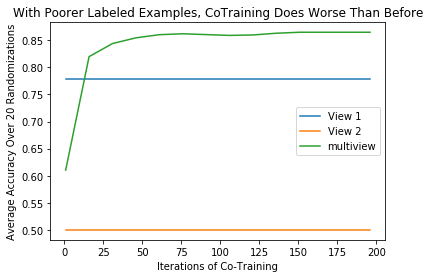

In [217]:
# make a figure from the data
plt.figure()
plt.plot(N_iters, acc_view1*np.ones(N_iters.shape))
plt.plot(N_iters, acc_view2*np.ones(N_iters.shape))
plt.plot(N_iters, acc_ct)
plt.legend(('View 1', 'View 2', 'multiview'))
plt.ylabel("Average Accuracy Over {} Randomizations".format(randomizations))
plt.xlabel('Iterations of Co-Training')
plt.title('With Poorer Labeled Examples, CoTraining Does Worse Than Before')
plt.show()

### Performance when data is overlapping

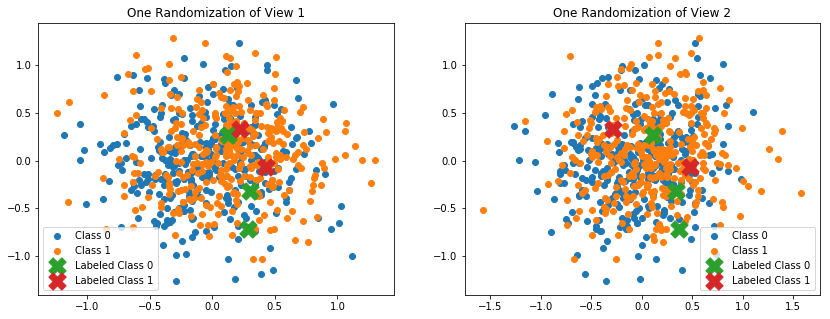

14


In [218]:
randomizations = 20
N_per_class = 500
view2_penalty = 'l1'
class2_mean_center = 0.1 # 1 would make this identical to first test

N_iters = np.arange(1, 202, 15)
acc_ct = [[] for _ in N_iters]
acc_view1 = []
acc_view2 = []


for count, iters in enumerate(N_iters):
    
    for seed in range(randomizations):
    
        ######################### Create Data ###########################
        np.random.seed(seed)

        view1_mu0 = np.zeros(2,)
        view1_mu1 = class2_mean_center * np.ones(2,)
        view1_cov = .2*np.eye(2)

        view2_mu0 = np.zeros(2,)
        view2_mu1 = class2_mean_center * np.ones(2,)
        view2_cov = .2*np.eye(2)

        view1_class0 = np.random.multivariate_normal(view1_mu0, view1_cov, size=N_per_class)
        view1_class1 = np.random.multivariate_normal(view1_mu1, view1_cov, size=N_per_class)

        view2_class0 = np.random.multivariate_normal(view2_mu0, view2_cov, size=N_per_class)
        view2_class1 = np.random.multivariate_normal(view2_mu1, view2_cov, size=N_per_class)

        View1 = np.concatenate((view1_class0, view1_class1))
        View2 = np.concatenate((view2_class0, view2_class1))
        Labels = np.concatenate((np.zeros(N_per_class,), np.ones(N_per_class,)))
    
        
        # Split both views into testing and training
        View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, Labels, test_size=0.3, random_state=42)
        View2_train, View2_test, labels_train_full, labels_test_full = train_test_split(View2, Labels, test_size=0.3, random_state=42)

        labels_train = labels_train_full.copy()
        labels_test = labels_test_full.copy()

        # randomly remove some labels
        np.random.seed(11)
        remove_idx = np.random.rand(len(labels_train),) < .99
        labels_train[remove_idx] = np.nan
        not_removed = np.where(remove_idx==False)[0]
        
        # make sure both classes have at least 1 labeled example
        if len(set(labels_train[not_removed])) != 2:
            continue
            
        if seed == 0 and count == 0:
            
            labeled_idx_class0 = not_removed[np.where(labels_train[not_removed]==0)]
            labeled_idx_class1 = not_removed[np.where(labels_train[not_removed]==1)]
            
            # plot the views
            plt.figure()
            fig, ax = plt.subplots(1,2, figsize=(14,5))

            ax[0].scatter(View1_train[idx_train_0,0], View1_train[idx_train_0,1])
            ax[0].scatter(View1_train[idx_train_1,0], View1_train[idx_train_1,1])
            ax[0].scatter(View1_train[labeled_idx_class0,0], View1_train[labeled_idx_class0,1], s=300, marker='X')
            ax[0].scatter(View1_train[labeled_idx_class1,0], View1_train[labeled_idx_class1,1], s=300, marker='X')
            ax[0].set_title('One Randomization of View 1')
            ax[0].legend(('Class 0', 'Class 1', 'Labeled Class 0', 'Labeled Class 1'))

            ax[1].scatter(View2_train[idx_train_0,0], View1_train[idx_train_0,1])
            ax[1].scatter(View2_train[idx_train_1,0], View1_train[idx_train_1,1])
            ax[1].scatter(View2_train[labeled_idx_class0,0], View1_train[labeled_idx_class0,1], s=300, marker='X')
            ax[1].scatter(View2_train[labeled_idx_class1,0], View1_train[labeled_idx_class1,1], s=300, marker='X')
            ax[1].set_title('One Randomization of View 2')
            ax[1].legend(('Class 0', 'Class 1', 'Labeled Class 0', 'Labeled Class 1'))

            plt.show()

        
        ############## Single view semi-supervised learning ##############
        # Only once, since not affected by "num iters"
        if count == 0:
#             gnb0 = KNeighborsClassifier(n_neighbors=N_neigh) # LogisticRegression()
#             gnb1 = KNeighborsClassifier(n_neighbors=N_neigh) # LogisticRegression()
            gnb0 = LogisticRegression()
            gnb1 = LogisticRegression(penalty=view2_penalty)

            # Train on only the examples with labels
            gnb0.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred0 = gnb0.predict(View1_test)

            gnb1.fit(View2_train[not_removed,:].squeeze(), labels_train[not_removed])
            y_pred1 = gnb1.predict(View2_test)

            accuracy_view1 = (accuracy_score(labels_test, y_pred0))
            accuracy_view2 = (accuracy_score(labels_test, y_pred1))

            acc_view1.append(accuracy_view1)
            acc_view2.append(accuracy_view2)
#             print("single view")
#             print(accuracy_view1)
#             print(accuracy_view2)


        ##################### Multiview ########################################
        ctc = CTClassifier(LogisticRegression(), LogisticRegression(penalty=view2_penalty))
        ctc.fit([View1_train, View2_train], labels_train, num_iter=iters)
        y_pred_ct = ctc.predict([View1_test, View2_test])
        acc_ct[count].append((accuracy_score(labels_test, y_pred_ct)))
#         print("cotraining")
#         print((accuracy_score(labels_test, y_pred_ct)))
        
acc_view1 = np.mean(acc_view1)
acc_view2 = np.mean(acc_view2)
print(len(acc_ct))
acc_ct = [sum(row) / float(len(row)) for row in acc_ct]




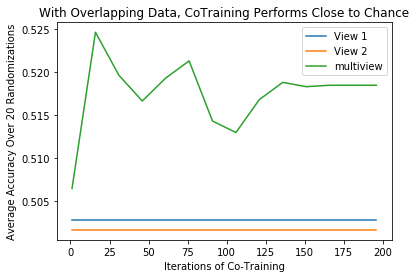

In [219]:
# make a figure from the data
plt.figure()
plt.plot(N_iters, acc_view1*np.ones(N_iters.shape))
plt.plot(N_iters, acc_view2*np.ones(N_iters.shape))
plt.plot(N_iters, acc_ct)
plt.legend(('View 1', 'View 2', 'multiview'))
plt.ylabel("Average Accuracy Over {} Randomizations".format(randomizations))
plt.xlabel('Iterations of Co-Training')
plt.title('With Overlapping Data, CoTraining Performs Close to Chance')
plt.show()

### Performance as labeled data proportion (essentially sample size) changes

In [147]:
data, labels = load_UCImultifeature(select_labeled=[0,1])

# Use only the first 2 views as an example
View0, View1 = data[0], data[1]

# Split both views into testing and training
View0_train, View0_test, labels_train_full, labels_test_full = train_test_split(View0, labels, test_size=0.33, random_state=42)
View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, labels, test_size=0.33, random_state=42)




In [30]:
N_labeled_full = []
acc_ct_full = []
acc_v0_full = []
acc_v1_full = []

acc_ct_flip_full = []
acc_ct_flip50_full = []

Reverse_Labels = True

iters = 500

for i, num in zip(np.linspace(0.03, .30, 20), (np.linspace(4, 30, 20)).astype(int)):
    
    N_labeled = []
    acc_ct = []
    acc_v0 = []
    acc_v1 = []
    
    acc_ct_flip = []
    acc_ct_flip50 = []
    
    View0_train, View0_test, labels_train_full, labels_test_full = train_test_split(View0, labels, test_size=0.33, random_state=42)
    View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, labels, test_size=0.33, random_state=42)
    
    for seed in range(iters):
    
        labels_train = labels_train_full.copy()
        labels_test = labels_test_full.copy()
        
        # Randomly remove all but 4 of the labels
        np.random.seed(2*seed) #6
        remove_idx = np.random.rand(len(labels_train),) < 1-i
        labels_train[remove_idx] = np.nan
        not_removed = np.where(remove_idx==False)[0]
        not_removed = not_removed[:num]
        N_labeled.append(len(labels_train[not_removed])/len(labels_train))
        if len(set(labels_train[not_removed])) != 2:
            continue
        
        if Reverse_Labels:
            labels_one_idx = np.argwhere(labels_train == 1)
            labels_zero_idx = np.argwhere(labels_train == 0)
            labels_trainFlipped = labels_train.copy()
            labels_trainFlipped50 = labels_trainFlipped.copy()
            labels_trainFlipped50[labels_one_idx[:len(labels_one_idx)//2]] = 0
            labels_trainFlipped50[labels_zero_idx[:len(labels_zero_idx)//2]] = 1
            labels_trainFlipped[labels_one_idx[:len(labels_one_idx)]] = 0
            labels_trainFlipped[labels_zero_idx[:len(labels_zero_idx)]] = 1
        ############## Single view semi-supervised learning ##############
        #-----------------------------------------------------------------
        gnb0 = GaussianNB()
        gnb1 = GaussianNB()

        # Train on only the examples with labels
        gnb0.fit(View0_train[not_removed,:].squeeze(), labels_train[not_removed])

        y_pred0 = gnb0.predict(View0_test)
        gnb1.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
        y_pred1 = gnb1.predict(View1_test)

        acc_v0.append(accuracy_score(labels_test, y_pred0))
        acc_v1.append(accuracy_score(labels_test, y_pred1))

        ######### Multi-view co-training semi-supervised learning #########
        #------------------------------------------------------------------
        # Train a CTClassifier on all the labeled and unlabeled training data
        ctc = CTClassifier()
        ctc.fit([View0_train, View1_train], labels_train)
        y_pred_ct = ctc.predict([View0_test, View1_test])
        acc_ct.append(accuracy_score(labels_test, y_pred_ct))
        
        ###################################################################
        # Flipped labels
        ######### Multi-view co-training semi-supervised learning #########
        #------------------------------------------------------------------
        # Train a CTClassifier on all the labeled and unlabeled training data
        if Reverse_Labels:
            ctc_flip = CTClassifier()
            ctc_flip.fit([View0_train, View1_train], labels_trainFlipped)
            y_pred_ct_flip = ctc_flip.predict([View0_test, View1_test])
            acc_ct_flip.append(accuracy_score(labels_test, y_pred_ct_flip))
            
            ctc_flip50 = CTClassifier()
            ctc_flip50.fit([View0_train, View1_train], labels_trainFlipped50)
            y_pred_ct_flip50 = ctc_flip50.predict([View0_test, View1_test])
            acc_ct_flip50.append(accuracy_score(labels_test, y_pred_ct_flip50))

            
        
    print(i)
        
    acc_ct_full.append(np.mean(acc_ct))
    acc_v0_full.append(np.mean(acc_v0))
    acc_v1_full.append(np.mean(acc_v1))
    N_labeled_full.append(np.mean(N_labeled))
    if Reverse_Labels:
        acc_ct_flip_full.append(np.mean(acc_ct_flip))
        acc_ct_flip50_full.append(np.mean(acc_ct_flip50))

0.03
0.0442105263158
0.0584210526316
0.0726315789474
0.0868421052632
0.101052631579
0.115263157895
0.129473684211
0.143684210526
0.157894736842
0.172105263158
0.186315789474
0.200526315789
0.214736842105
0.228947368421
0.243157894737
0.257368421053
0.271578947368
0.285789473684
0.3


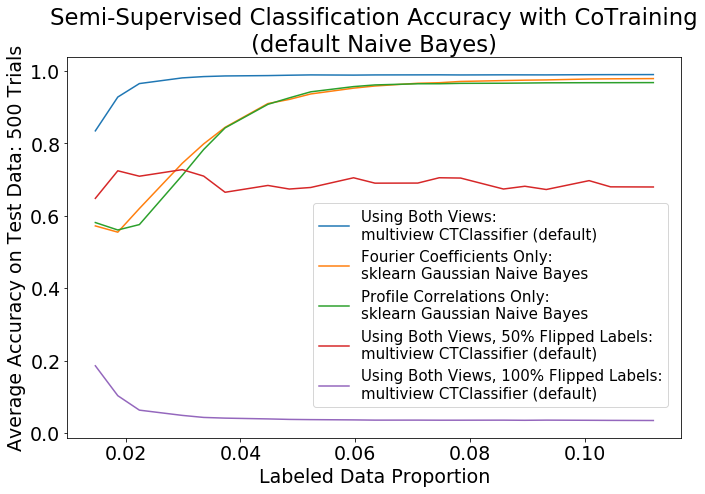

In [43]:
matplotlib.rcParams.update({'font.size': 19})
if Reverse_Labels:
    plt.figure(figsize=(11,7))
    plt.plot(N_labeled_full, acc_ct_full)
    plt.plot(N_labeled_full, acc_v0_full)
    plt.plot(N_labeled_full, acc_v1_full)
    plt.plot(N_labeled_full, acc_ct_flip50_full)
    plt.plot(N_labeled_full, acc_ct_flip_full)
    
    plt.legend(("Using Both Views:\nmultiview CTClassifier (default)", "Fourier Coefficients Only:\nsklearn Gaussian Naive Bayes", "Profile Correlations Only:\nsklearn Gaussian Naive Bayes", "Using Both Views, 50% Flipped Labels:\nmultiview CTClassifier (default)", "Using Both Views, 100% Flipped Labels:\nmultiview CTClassifier (default)"), loc=(.4, .08), fontsize=15)
    plt.title("Semi-Supervised Classification Accuracy with CoTraining\n(default Naive Bayes)")
    plt.xlabel("Labeled Data Proportion")
    plt.ylabel("Average Accuracy on Test Data: {} Trials".format(iters))
    #plt.savefig('AvgAccuracy_CTClassifier_withFlipped.png', bbox_inches='tight')
    plt.show()
    
else:
    plt.figure()
    plt.plot(N_labeled_full, acc_ct_full)
    plt.plot(N_labeled_full, acc_v0_full)
    plt.plot(N_labeled_full, acc_v1_full)
    plt.legend(("Using Both Views:\nmultiview CTClassifier (default)", "Fourier Coefficients Only:\nsklearn Gaussian Naive Bayes", "Profile Correlations Only:\nsklearn Gaussian Naive Bayes"))
    plt.title("Semi-Supervised Classification Accuracy with CoTraining\n(default Naive Bayes)")
    plt.xlabel("Labeled Data Proportion")
    plt.ylabel("Average Accuracy on Test Data: {} Trials".format(iters))
    #plt.savefig('AvgAccuracy_CTClassifier.png', bbox_inches='tight')
    plt.show()
